# ***Random Forest***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import os
import pickle  # For saving and loading the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, f1_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay
import optuna
from sklearn.ensemble import RandomForestClassifier


pd.options.display.float_format = '{:.3f}'.format

In [2]:
df = pd.read_excel("../Preprocessed data.xlsx")
#df.columns

Sizes:
 - Training: 22243
 - Validation: 4767
 - Testing: 4767
Study found. Loading from ../Study/optuna_study_RF_cv.pkl...
Model found. Loading from ../Models/rf_model_cv.pkl...

Validation Metrics:
F1-Score (Validation): 0.8501
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      3211
           1       0.67      0.74      0.70       970
           2       0.72      0.76      0.74       586

    accuracy                           0.85      4767
   macro avg       0.77      0.80      0.79      4767
weighted avg       0.85      0.85      0.85      4767



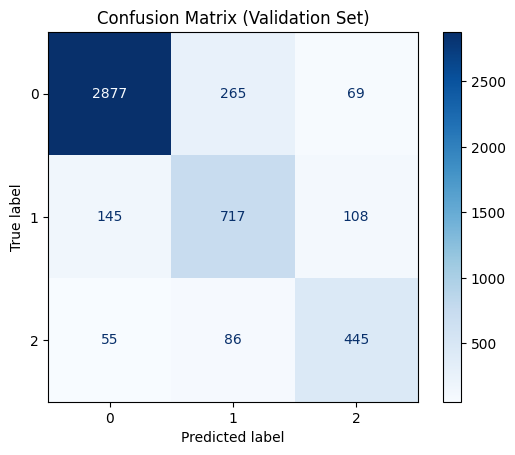

In [3]:
import os
import joblib
import pandas as pd
import optuna
import time
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, KFold

# Cargar datos
X = df.drop(columns=["Cuenta", "Estado"])
y = df["Estado"]

# Dividir en entrenamiento, validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Sizes:\n - Training: {len(X_train)}\n - Validation: {len(X_val)}\n - Testing: {len(X_test)}")

# Definir nombres de archivos
model_filename = "../Models/rf_model_cv.pkl"
study_filename = "../Study/optuna_study_RF_cv.pkl"

# Función objetivo para Optuna con validación cruzada
def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 150),
        "max_depth": trial.suggest_int("max_depth", 3, 9),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "ccp_alpha": trial.suggest_float("ccp_alpha", 0.0001, 0.01, log=True),
    }
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []
    
    for train_index, val_index in kf.split(X_train):
        X_t, X_v = X_train.iloc[train_index], X_train.iloc[val_index]
        y_t, y_v = y_train.iloc[train_index], y_train.iloc[val_index]
        
        model = RandomForestClassifier(**param, random_state=42, class_weight="balanced", n_jobs=-1)
        model.fit(X_t, y_t)
        y_v_pred = model.predict(X_v)
        f1_scores.append(f1_score(y_v, y_v_pred, average="weighted"))
    
    return np.mean(f1_scores)

# Cargar o crear estudio de Optuna
if os.path.exists(study_filename):
    print(f"Study found. Loading from {study_filename}...")
    study_rf = joblib.load(study_filename)
else:
    print("Study not found. Creating a new one...")
    study_rf = optuna.create_study(direction="maximize")
    start_time = time.time()
    study_rf.optimize(objective, n_trials=100)
    end_time = time.time()
    joblib.dump(study_rf, study_filename)
    print(f"Study saved as {study_filename}")
    print(f"Best parameters: {study_rf.best_params}")
    print(f"Optimization time: {end_time - start_time:.2f} seconds")

# Entrenar modelo final con mejores hiperparámetros
if os.path.exists(model_filename):
    print(f"Model found. Loading from {model_filename}...")
    rf_model = joblib.load(model_filename)
else:
    print("Model not found. Training a new one...")
    best_params = study_rf.best_params
    rf_model = RandomForestClassifier(**best_params, random_state=42, class_weight="balanced", n_jobs=-1)
    rf_model.fit(X_train, y_train)
    joblib.dump(rf_model, model_filename)
    print(f"Model saved as {model_filename}")

# Evaluación en validación
y_val_pred = rf_model.predict(X_val)
print("\nValidation Metrics:")
print(f"F1-Score (Validation): {f1_score(y_val, y_val_pred, average='weighted'):.4f}")
print(classification_report(y_val, y_val_pred))

# Matriz de confusión
conf_matrix_val = confusion_matrix(y_val, y_val_pred)
disp_val = ConfusionMatrixDisplay(conf_matrix_val, display_labels=rf_model.classes_)
disp_val.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Validation Set)")
plt.show()


In [4]:
from reporte_metricas import guardar_reporte

guardar_reporte(y_val, y_val_pred, "RF Model", "./Metrics/Train_Metrics.csv", "./Metrics/Train_Metrics.json")

📂 Reporte de RF Model guardado correctamente.


## ***Test Metrics***

In [5]:
# Evaluar en el conjunto de prueba
y_test_pred = rf_model.predict(X_test)

f1_test = f1_score(y_test, y_test_pred, average='weighted')

# Reporte de clasificación y matriz de confusión para `test`
print("\nFinal Metrics on Test Set:")
print(f"F1-Score (Test): {f1_test:.4f}")
print(classification_report(y_test, y_test_pred))



Final Metrics on Test Set:
F1-Score (Test): 0.8604
              precision    recall  f1-score   support

           0       0.94      0.91      0.93      3212
           1       0.70      0.75      0.72       969
           2       0.70      0.74      0.72       586

    accuracy                           0.86      4767
   macro avg       0.78      0.80      0.79      4767
weighted avg       0.86      0.86      0.86      4767




Confusion Matrix for Test:


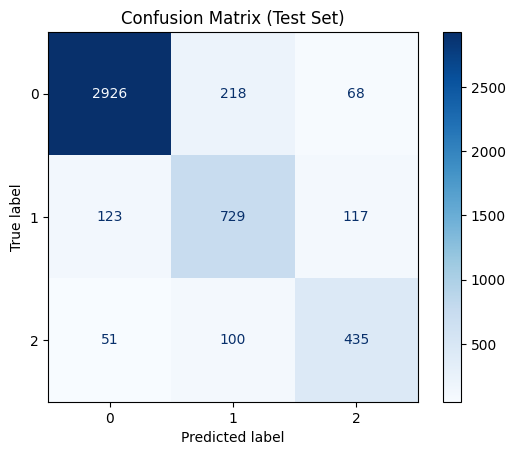

In [6]:
print("\nConfusion Matrix for Test:")
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(conf_matrix_test, display_labels=rf_model.classes_)
disp_test.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Test Set)")
plt.show()

## ***Optuna Visualization***

In [7]:
optuna.visualization.plot_optimization_history(study_rf)

In [8]:
optuna.visualization.plot_parallel_coordinate(study_rf)

In [9]:
# Extract F1-scores from each trial in the study
f1_scores = [study_rf.trials[i].value for i in range(len(study_rf.trials))]  # Get the F1-score for each trial

# Create a plotly figure
fig = go.Figure()

# Add a line plot to the figure with the F1-scores
fig.add_trace(go.Scatter(
    x=list(range(len(study_rf.trials))),  # X-axis: Trial number
    y=f1_scores,  # Y-axis: F1-score values
    mode='markers+lines',  # Display both markers and lines
    name='F1-score',  # Label for the line
    line=dict(color='blue'),  # Line color
    marker=dict(color='blue', size=6)  # Marker style
))

# Update layout for the plot
fig.update_layout(
    title="F1-Score Evolution During Optuna Optimization",  # Title of the plot
    xaxis_title="Trial",  # Label for X-axis
    yaxis_title="F1-Score",  # Label for Y-axis
    template="plotly_dark",  # Use dark template for better visibility
    showlegend=False  # Hide legend
)

# Show the plot
fig.show()


In [10]:
optuna.visualization.plot_slice(study_rf, params=['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features', 'bootstrap', 'ccp_alpha'])

In [11]:
optuna.visualization.plot_param_importances(study_rf)

## ***Feature Importances***

In [12]:
# Extract feature importances from the trained model
importances = rf_model.feature_importances_

# Create a DataFrame for easier plotting
feature_names = X_train.columns  # Use the features from the final training set
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance and select the top 20
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(20)

# Plot the feature importance using Plotly
fig = px.bar(importance_df, 
             x='Feature', 
             y='Importance', 
             title='Top 20 Feature Importance of the Decision Tree Model',
             labels={'Feature': 'Feature Name', 'Importance': 'Importance Score'},
             color='Importance',  # Color bars based on importance
             color_continuous_scale='Viridis',  # Use a color scale for better visualization
             text='Importance')  # Display importance values on the bars

# Rotate X-axis labels for better readability
fig.update_layout(xaxis_tickangle=45)

# Show the plot
fig.show()


/home/ssilvera/Escritorio/Proyectos/Modelo_pagos/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



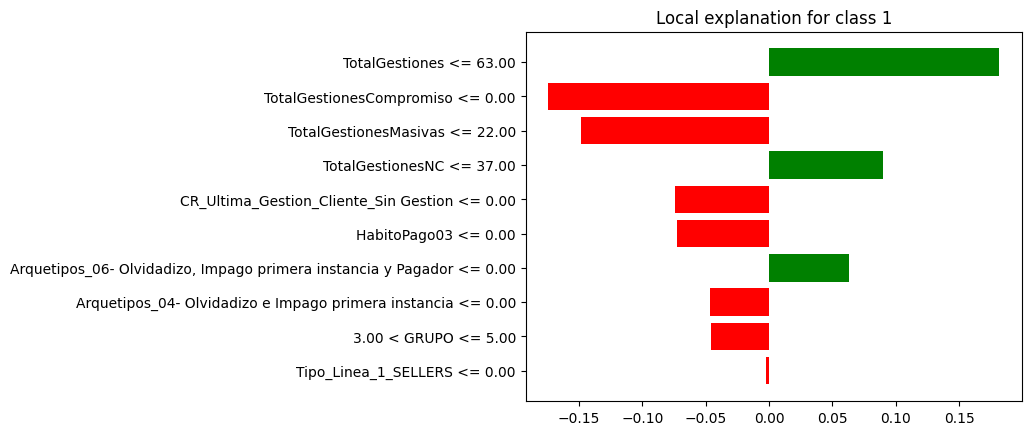

In [13]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,               # Training data (must be a numpy array or pandas dataframe)
    feature_names=X_train.columns,                    # Feature names (column names)
    class_names=y_train.unique(),                     # Target class names (unique classes in target column)
    mode='classification',                             # We're explaining a classification problem
    training_labels=y_train.values                     # Labels for training data
)

# Example 1: Explaining the prediction for the 100th instance in the test set
i = 3
instance = X_test.iloc[i].values.reshape(1, -1)  # Reshape for LIME

exp = explainer.explain_instance(
    data_row=instance[0],                           # Instance to explain
    predict_fn=rf_model.predict_proba              # Model's predict function (predict_proba for probabilities)
)

# Show explanation in notebook (table of feature importances)
exp.show_in_notebook(show_table=True, show_all=False)

# Generate a plot for the explanation
fig = exp.as_pyplot_figure()
plt.show()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.588562 to fit


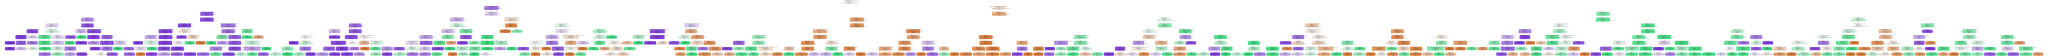

In [14]:
from sklearn.tree import export_graphviz
import graphviz

tree = rf_model.estimators_[0]

# Exportar el árbol a formato DOT
dot_data = export_graphviz(
    tree, 
    out_file=None, 
    feature_names=X.columns,  # Nombres de las características
    class_names=[str(c) for c in rf_model.classes_],  # Nombres de las clases
    filled=True,  # Colorear nodos
    rounded=True,  # Esquinas redondeadas
    special_characters=True
)

# Renderizar con Graphviz
graph = graphviz.Source(dot_data)
graph.render("./img/random_forest_tree_bal", format="png")  # Guarda como imagen
graph  # Muestra en Jupyter Notebook


In [15]:
rf_model

RandomForestClassifier(ccp_alpha=0.00013226680501352063,
                       class_weight='balanced', max_depth=9, max_features=None,
                       min_samples_leaf=5, min_samples_split=7,
                       n_estimators=119, n_jobs=-1, random_state=42)

In [16]:
from reporte_metricas import guardar_reporte

guardar_reporte(y_val, y_val_pred, "RF Model", "./Metrics/Test_Metrics.csv", "./Metrics/Test_Metrics.json")

📂 Reporte de RF Model guardado correctamente.
